### Setup

In [1]:
# importing libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tq
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# for deep learning
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout, Activation

In [2]:
# random seed for controlling randomization
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# configuration
def img2array(dir, is_train, flatn=False, color=False, shape=(64, 64)):
    """This function will do the following task
    * Convert an image to numpy array either of colored or gray scale image
    * Normalize the array
    * Flattent the array, if asked"""
    
    # importing dependencies
    import os 
    import cv2
    
    
    features = []
    label = []
    categories = os.listdir(dir)
    
    for cat in tq(categories):
        for img in tq(os.listdir(dir+cat)):
            img_pth = os.path.join(dir, cat, img)
            img = cv2.imread(img_pth, int(color))/255 # image normailization
            img = cv2.resize(img, shape)
            # image flattening and color scaling
            if flatn==True and color==True:
                img = img.reshape(64*64*3, 1)
            elif flatn==True and color==False:
                img = img.reshape(64*64, 1)
            else: pass

            # storing image data in lst
            features.append(img)
            label.append((0, 1)[cat=='hi'])
            
    # final output 
    features = np.array(features)
    label = np.array(label)
    
    if is_train==True:
        return  (features, label) if color else (features.reshape(-1, *shape+(1,)), label)
    else:
        return features if color else features.reshape(-1, *shape+(1,))
def plot_performance(history):
    """This function will plot Accuracy and Loss graph of 
        Deep learning model"""
    # modle performance visualization
    # subplot
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # accuracy
    ax1.plot(history['accuracy'], color='red')
    ax1.plot(history['val_accuracy'], color='green')
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    # "Loss"
    ax2.plot(history['loss'], color='red')
    ax2.plot(history['val_loss'], color='green')
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper right')
    plt.show()

### Data

In [4]:
# loading all images into array
features, label = img2array('train/', is_train=True)
test_feat = img2array('test/', is_train=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4450 [00:00<?, ?it/s]

  0%|          | 0/1425 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [5]:
print(f'Shape of features: {features.shape}\n\
Shape of label: {label.shape}\n\
Shape of test: {test_feat.shape} ')

Shape of features: (5875, 64, 64, 1)
Shape of label: (5875,)
Shape of test: (98, 64, 64, 1) 


### EDA

In [6]:
# image counts
hi = list(os.listdir('train/hi/'))
bg = list(os.listdir('train/background/'))
tst = list(os.listdir('test/test/'))

print(f'There are total {len(hi)} hindi character images in hi folder')
print(f'There are total {len(bg)} background images in background folder')
print(f'There are total {len(tst)} test images in test folder')

There are total 1425 hindi character images in hi folder
There are total 4450 background images in background folder
There are total 98 test images in test folder


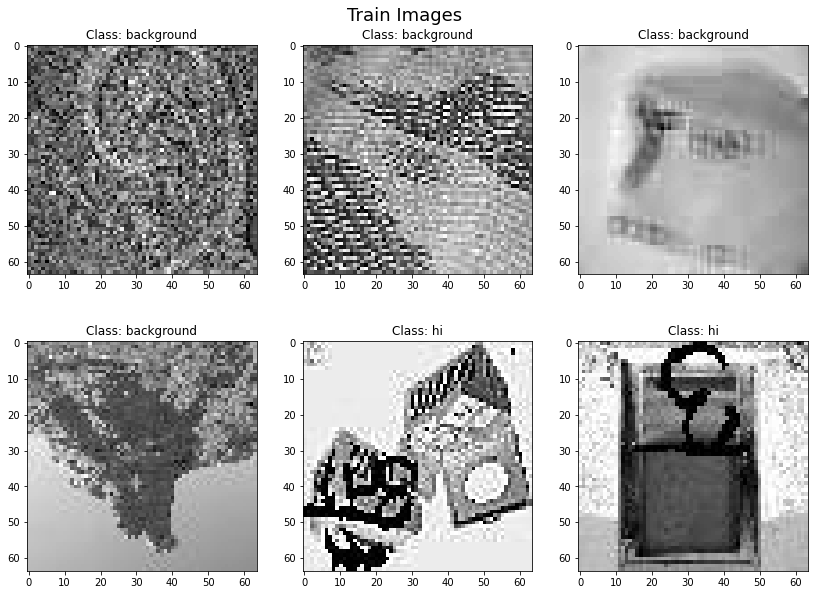

In [7]:
# train images
# subplot
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
fig.suptitle('Train Images', fontsize=18, x=0.5, y=0.92)
for i in range(2):
    for j in range(3):
        rndm_ind = np.random.randint(0, 5875, )
        # plot it
        ax[i][j].imshow(features[rndm_ind], cmap='gray')
        ax[i][j].set_title('Class: '+('background', 'hi')[int(label[rndm_ind])==1])

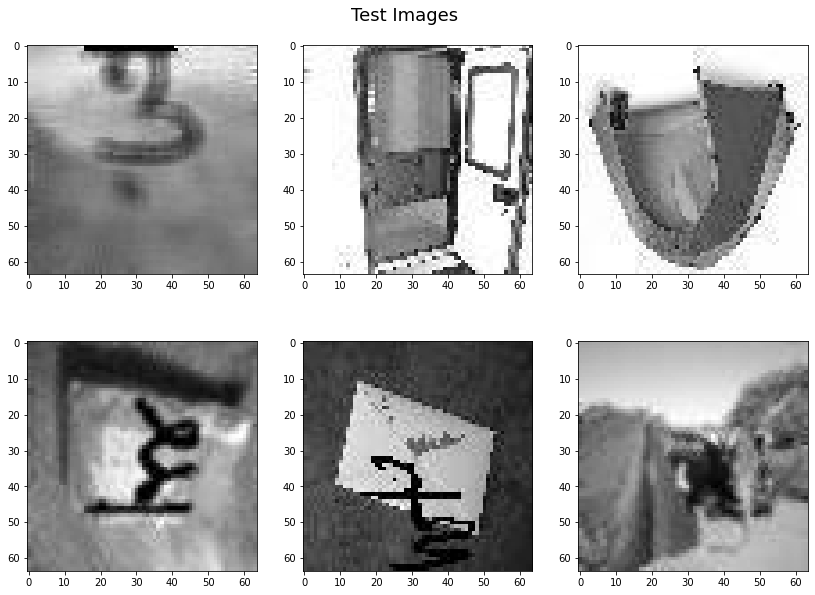

In [8]:
# test images
# subplot
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
fig.suptitle('Test Images', fontsize=18, x=0.5, y=0.92)
for i in range(2):
    for j in range(3):
        rndm_ind = np.random.randint(0, 98, )
        # plot it
        ax[i][j].imshow(test_feat[rndm_ind], cmap='gray')

### Model

In [9]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=21)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4700, 64, 64, 1) (1175, 64, 64, 1) (4700,) (1175,)


In [10]:
# sequential model
model = Sequential()
# convolution layer
model.add(Conv2D(filters=50, kernel_size=(2, 2), input_shape = (64, 64, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# convolution layer
model.add(Conv2D(filters=50, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# convolution layer
model.add(Conv2D(filters=50, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# flattening
model.add(Flatten())
# hidden layer
model.add(Dense(50))
model.add(Dropout(0.5))
# output layer
model.add(Dense(1, activation='sigmoid'))

# compiling model
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])

In [11]:
# callbacks
mc_loss = ModelCheckpoint('Models/best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# fitting model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, callbacks=[mc_loss])

Epoch 1/50
147/147 [==============================] - 34s 120ms/step - loss: 0.5598 - accuracy: 0.7403 - val_loss: 0.3511 - val_accuracy: 0.8579

Epoch 00001: val_loss improved from inf to 0.35109, saving model to Models\best_model.h5
Epoch 2/50
147/147 [==============================] - 20s 139ms/step - loss: 0.3194 - accuracy: 0.8743 - val_loss: 0.2400 - val_accuracy: 0.9157

Epoch 00002: val_loss improved from 0.35109 to 0.24001, saving model to Models\best_model.h5
Epoch 3/50
147/147 [==============================] - 26s 179ms/step - loss: 0.2325 - accuracy: 0.9175 - val_loss: 0.2122 - val_accuracy: 0.9302

Epoch 00003: val_loss improved from 0.24001 to 0.21217, saving model to Models\best_model.h5
Epoch 4/50
147/147 [==============================] - 25s 168ms/step - loss: 0.2119 - accuracy: 0.9222 - val_loss: 0.1671 - val_accuracy: 0.9455

Epoch 00004: val_loss improved from 0.21217 to 0.16713, saving model to Models\best_model.h5
Epoch 5/50
147/147 [============================

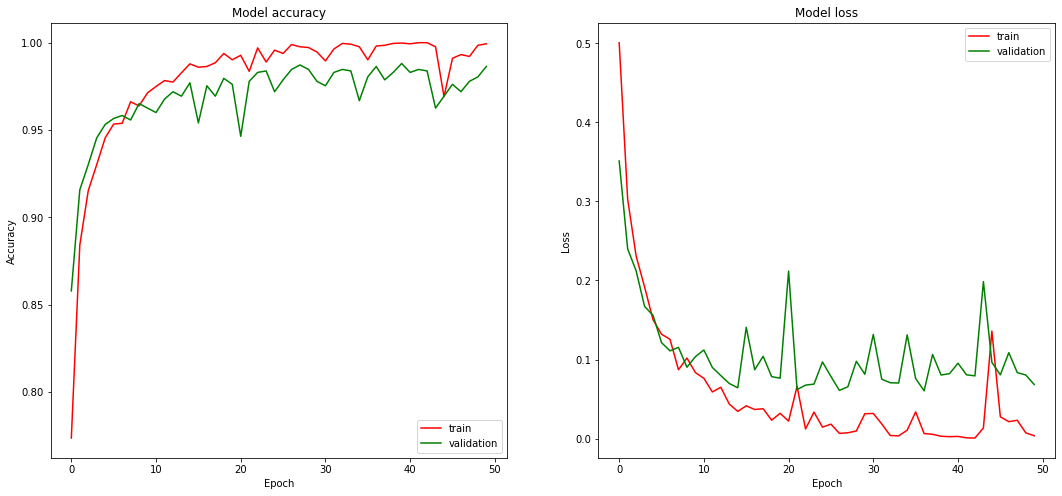

In [13]:
# model performance graph
plot_performance(history.history)

In [14]:
# accuracy of the model
svd_model = keras.models.load_model('Models/best_model.h5')
print(model.evaluate(x_train, y_train, verbose=0))
print(model.evaluate(x_test, y_test, verbose=0))

[0.001685619237832725, 1.0]
[0.06837262958288193, 0.9863829612731934]


In [15]:
y_pred = svd_model.predict(x_test)
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.97      0.97      0.97       271

    accuracy                           0.99      1175
   macro avg       0.98      0.98      0.98      1175
weighted avg       0.99      0.99      0.99      1175



### Submission

In [16]:
# model prediction
test_target = svd_model.predict(test_feat)

In [17]:
# submission file
tst_files = list(os.listdir('test/test/'))
target = np.round(test_target)

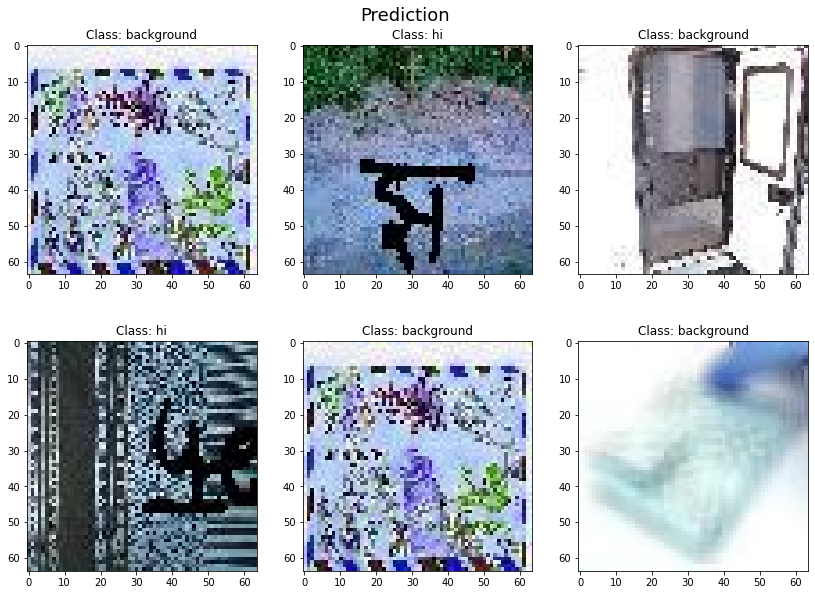

In [23]:
# prediction
# subplot
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
fig.suptitle('Prediction', fontsize=18, x=0.5, y=0.92)
for i in range(2):
    for j in range(3):
        rndm_ind = np.random.randint(0, 98)
        img_pth = 'test/test/'+tst_files[rndm_ind]
        img = cv2.imread(img_pth)
        # plot it
        ax[i][j].imshow(img)
        ax[i][j].set_title('Class: '+('background', 'hi')[int(target[rndm_ind])==1])

In [24]:
sub = {x[:-4]+'.png': float(y[0]) for x, y in zip(tst_files, target)}
pd.DataFrame({'Image_ID': sub.keys(), 'Target':sub.values()}).head()

,Image_ID,Target
0,1.png,1.0
1,10.png,0.0
2,11.png,1.0
3,12.png,0.0
4,13.png,1.0


In [25]:
# exporting file
import json

with open("sub.json", "w") as outfile:
    json.dump(sub, outfile)